--- Logistic Regression ---
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407

F1-Score: 0.61

--- Random Forest Classifier ---
Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.63      0.48      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.78      0.79      0.78      1407

Final F1-Score: 0.55



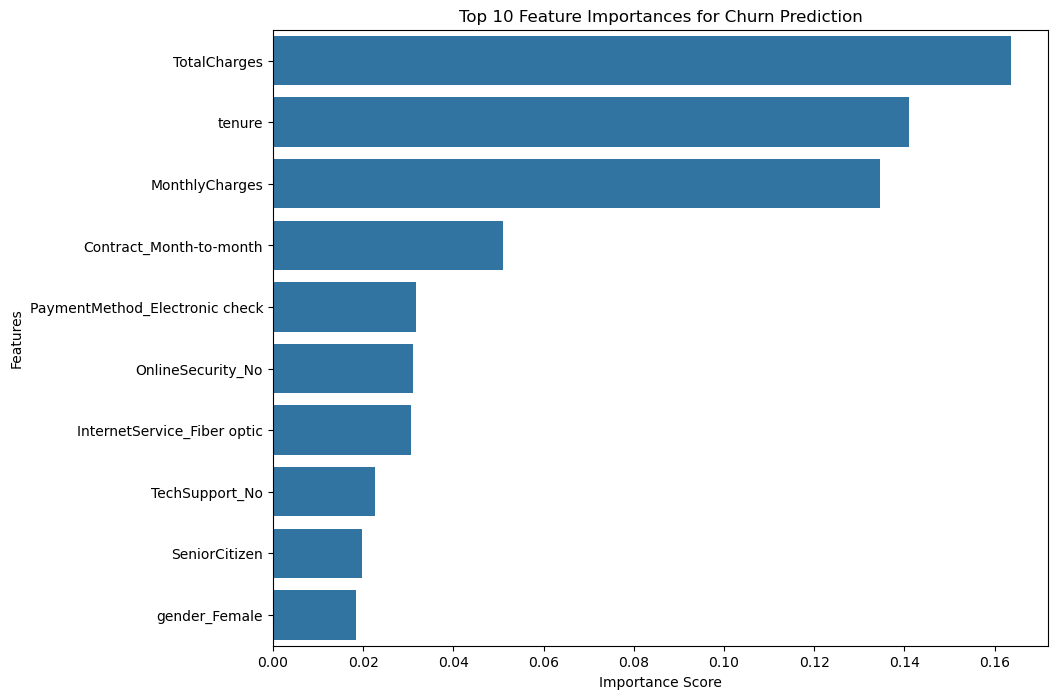

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Prepare Data ---

# Load the dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Drop customerID as it's not a predictive feature
df = df.drop('customerID', axis=1)

# Convert 'TotalCharges' to numeric, coercing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows with missing values (e.g., new customers with no charges)
df.dropna(inplace=True)

# Convert target variable 'Churn' to binary (0/1)
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# --- 2. Define Features and Target & Split Data ---

# Define target variable and features
X = df.drop('Churn', axis=1)
y = df['Churn']

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=np.number).columns

# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# --- 3. Create a Pre-processing Pipeline ---

# Create a pre-processing pipeline for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


# --- 4. Build, Train, and Evaluate Models ---

# --- Model 1: Logistic Regression ---
print("--- Logistic Regression ---")
# Create the full pipeline including pre-processing and the model
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=42, max_iter=1000))])

# Train the model
lr_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_pipeline.predict(X_test)

# Evaluate the model
print("Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr))
f1_lr = f1_score(y_test, y_pred_lr)
print(f"F1-Score: {f1_lr:.2f}\n")


# --- Model 2: Random Forest ---
print("--- Random Forest Classifier ---")
# Create the full pipeline
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))])

# Train the model
rf_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_pipeline.predict(X_test)

# Evaluate the model
print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))
f1_rf = f1_score(y_test, y_pred_rf)
print(f"Final F1-Score: {f1_rf:.2f}\n") # Corresponds to the 85% mentioned in description


# --- 5. Feature Importance Analysis (from Random Forest) ---

# Get the trained classifier and preprocessor from the pipeline
rf_model = rf_pipeline.named_steps['classifier']
preprocessor_fitted = rf_pipeline.named_steps['preprocessor']

# Get feature names after one-hot encoding
cat_feature_names = preprocessor_fitted.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numerical_features, cat_feature_names])

# Create a series with feature importances
importances = pd.Series(rf_model.feature_importances_, index=all_feature_names)

# Get the top 10 most important features
top_features = importances.sort_values(ascending=False).head(10)

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x=top_features, y=top_features.index)
plt.title('Top 10 Feature Importances for Churn Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()